In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import pandas as pd
import numpy as np
from utils import *
from gtv import *

In [5]:
# load data obs
X = pd.read_csv('paper/data/X_obs.csv').values
y = pd.read_csv('paper/data/y_avg.csv').values.reshape(1,-1)[0]
fts = pd.read_csv('paper/data/sst_columns.csv')

# load LENS, compute covariance, and threshold for edge incidence
Xlens = pd.read_csv("paper/data/X_lens.csv").values
Xlens = preprocessing.scale(Xlens)
Slens = Xlens.T@Xlens/Xlens.shape[0]
Dlens = edge_incidence(Slens, .5)

# split data into train/test
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

# Bootstrap

In [6]:
lens_traj = [Xlens[i*66:(i+1)*66] for i in range(40)]
betas = []
errors = []
preds =[]
for i in range(1000):
    if i%100 == 0:
        print(i)
    boot_ix = np.random.choice(np.arange(40), 40, replace=True)
    Xlens_boot = lens_traj[boot_ix[0]]
    for i in boot_ix[1:]:
        Xlens_boot = np.vstack([Xlens_boot, lens_traj[boot_ix[i]]])

    Slens_boot = Xlens_boot.T@Xlens_boot/Xlens_boot.shape[0]
    Dlens_boot = edge_incidence(Slens_boot, .5)
    
    # from CV
    l1 = 0.0103 
    ltv = 0.0004
    
    try:
        beta = gtv_cvx(X_train, y_train, Dlens_boot, lambda_lasso=l1, lambda_tv=ltv, alpha=.9)
        betas.append(beta)
        yhat = X_test@beta
        preds.append(yhat)
        errors.append(r2_score(y_test, yhat))
    except:
        continue

0
100
200
300
400
500
600
700
800
900


(0.135, 0.51)

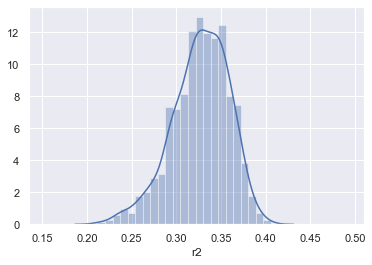

In [16]:
%matplotlib inline
boots = pd.DataFrame(errors, columns=['r2'])
sns.set()
sns.distplot(boots.r2)
plt.xlim(0.135, 0.51)
#plt.scatter(np.mean(boots), 0, s=100)

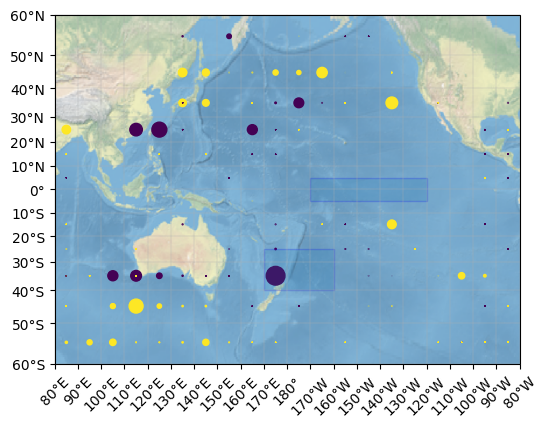

In [8]:
fts['coef'] = np.mean(betas, axis=0)/2
plot_coefs(fts)

In [10]:
max(abs(np.mean(betas, axis=0)))

0.362617387092163

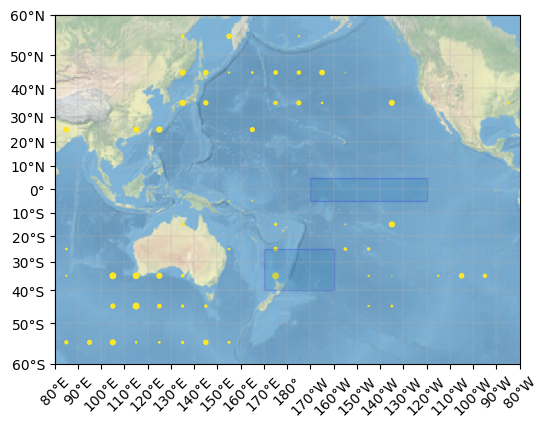

In [11]:
fts['coef'] = np.std(betas, axis=0)/2
plot_coefs(fts)

In [17]:
max(np.std(betas, axis=0))

0.032947940754010016

In [18]:
beta_boot = np.mean(betas, axis=0)
r2_score(y_test, X_test@beta_boot)

0.3337547530981432